# Credit Card Fraud Detection

### Overview 

In this project, I am trying to answer a very important question:
**Can the credit card fraud be predicted before authorization to stop it from happening?**

Credit card frauds are common. It happens for multiple reasons like due to stolen identity, lost credit card or when hackers hack the company's data. It's important to identify the fraud so that consumers aren't charged for the transaction(s) that they did not execute. It not only affects the consumers whose credit card was involved in the fraud but also costs millions to credit card company as most card companies provide protection to cardholders against frauds.

Adding fraud detection mechanism to card transactions might bring some inconvenience to cardholders, especially for False Positive cases, as they would have to confirm if they recognized the transaction (tagged as potential fraud) before transaction is approved by the card company. But in the end, avoiding the fraud is of greater importance than a minor inconvenience of confirming transaction's validity.


### Business Objective

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase. Business would like to get a tool that could predict if a given credit card transaction is likely a fraud or legit.

Business may not mind a certain percentage of false positive identification (labeling a genuine transaction as fraud) but avoiding false negatives (labeling a fraud transaction as genuine) is extremely important espcially for large amount transactions.

### Data Set Description

I am using the dataset from Kaggle which can be found [here](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

As per details given at Kaggle, the dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

This dataset does not contain actual feature names but rather are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Class' is the target variable and it takes value 1 in case of fraud and 0 otherwise.


### Step 1: Read the Data


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import time
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.tree import export_graphviz
from IPython.display import Image
from subprocess import call, check_call
from warnings import filterwarnings
filterwarnings("ignore")

### Read the Card Transactions Data

In [2]:
# The CSV file is huge 143MB. Keeping the data in zipfile and reading from it
data = pd.read_csv('data/creditcard.zip', compression = 'zip')

# # if it's preferred to read data directly from CSV file then simply extract the zipped file in the data folder
# # Comment the above code to read from zip file and uncomment below line to read it from CSV file
# data = pd.read_csv("data/creditcard.csv")

In [3]:
# Display data
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
print("Credit Card Transaction Data -  rows:",data.shape[0]," columns:", data.shape[1])

Credit Card Transaction Data -  rows: 284807  columns: 31


In [5]:
# Display the statistics of the data
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
# Display column details
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Check for Missing Data

In [7]:
data.isnull().sum().sort_values(ascending = False)

Time      0
V16       0
Amount    0
V28       0
V27       0
V26       0
V25       0
V24       0
V23       0
V22       0
V21       0
V20       0
V19       0
V18       0
V17       0
V15       0
V1        0
V14       0
V13       0
V12       0
V11       0
V10       0
V9        0
V8        0
V7        0
V6        0
V5        0
V4        0
V3        0
V2        0
Class     0
dtype: int64

**There is no missing data in the card transactions dataset**

In [8]:
# Check the value count of the Class values
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

**There are 284315 Legit Transactions and 492 Fraud Transactions.
Fraud Transactions are only ~0.18% of Total Transactions**

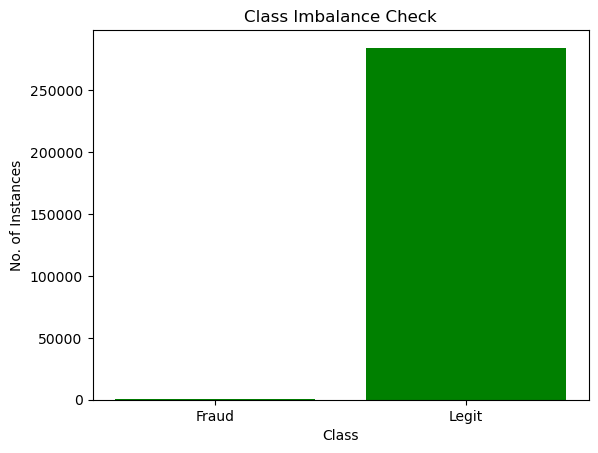

In [9]:
# Visualize the target feature distribution
fraud = list(data['Class'])
count_per_class = {'Fraud' : fraud.count(1), 'Legit' : fraud.count(0)}

plt.bar([0, 1], count_per_class.values(), color='green')
plt.xlabel('Class')
plt.ylabel('No. of Instances')
plt.title('Class Imbalance Check')
plt.xticks([0, 1], ['Fraud', 'Legit'])
plt.show()

### Exploratory Data Analysis (EDA)

**Aggregate Values of Transaction Amount Per Hour**

Assuming the given time is in seconds, we can convert it to hour and apply aggregate functions on it.

In [10]:
data['Hour'] = data['Time'].apply(lambda x: np.floor(x / 3600))

agg = data.groupby(['Hour', 'Class'])['Amount'].aggregate(['sum', 'mean', 'median','min', 'max', 'count']).reset_index()
agg_df = pd.DataFrame(agg)
agg_df.columns = ['Hour', 'Class', 'Sum', 'Mean', 'Median', 'Min', 'Max', 'Txn_Count']
agg_df.head()

,Hour,Class,Sum,Mean,Median,Min,Max,Txn_Count
0,0.0,0,256572.87,64.774772,12.990,0.0,7712.43,3961
1,0.0,1,529.00,264.500000,264.500,0.0,529.00,2
2,1.0,0,145806.76,65.826980,22.820,0.0,1769.69,2215
3,1.0,1,298.93,149.465000,149.465,59.0,239.93,2
4,2.0,0,106989.39,68.803466,17.900,0.0,4002.88,1555


**Visualize Total Transactions Amount Per Hour**

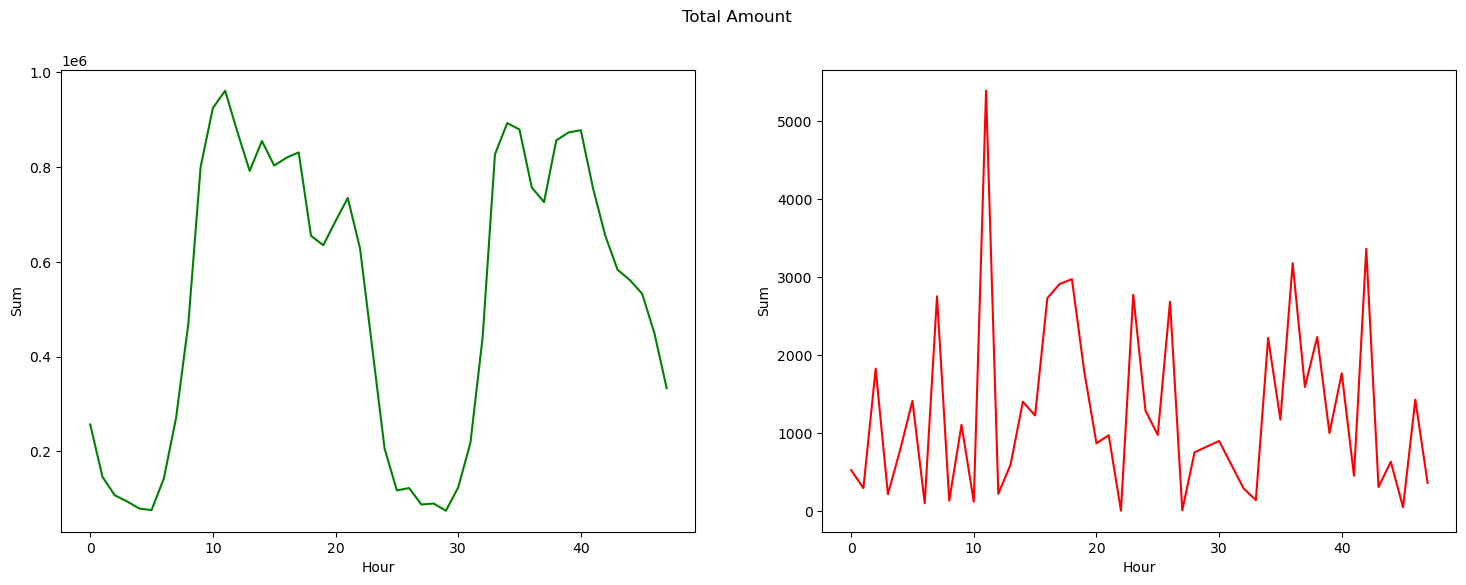

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=agg_df.loc[agg_df.Class==0], color="green")
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=agg_df.loc[agg_df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

**Visualize Average Transactions Amount Per Hour**

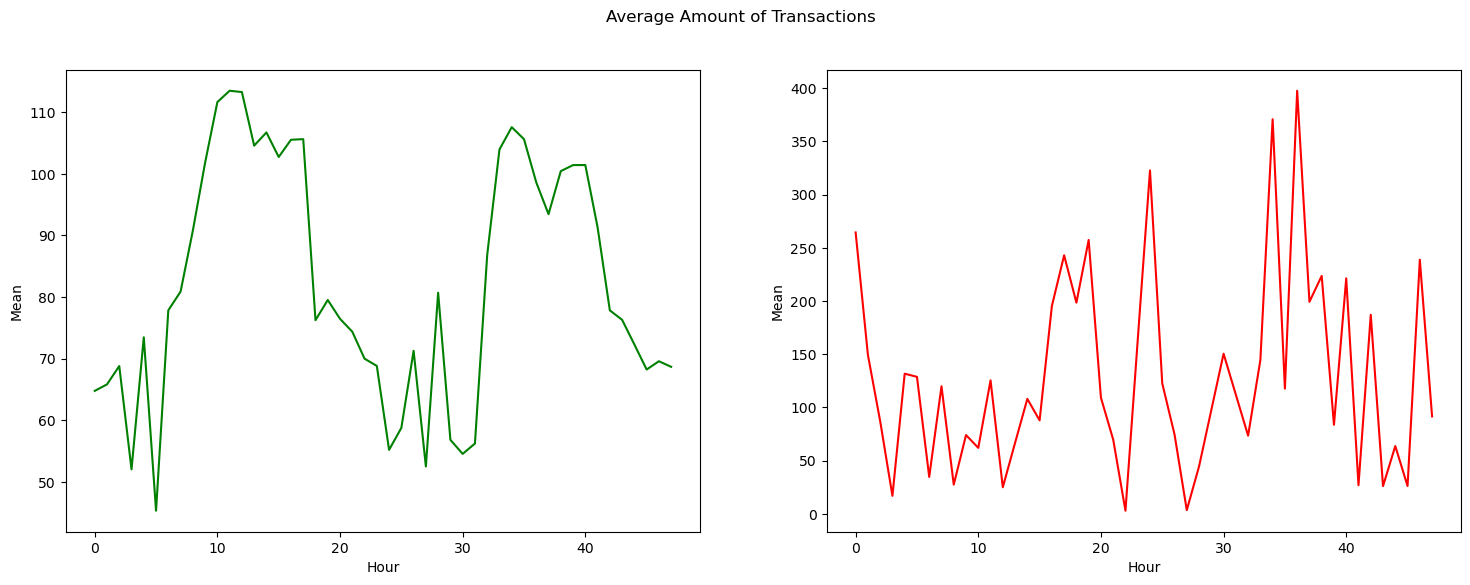

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=agg_df.loc[agg_df.Class==0], color="green")
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=agg_df.loc[agg_df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show();

**Visualize Median Transactions Amount Per Hour**

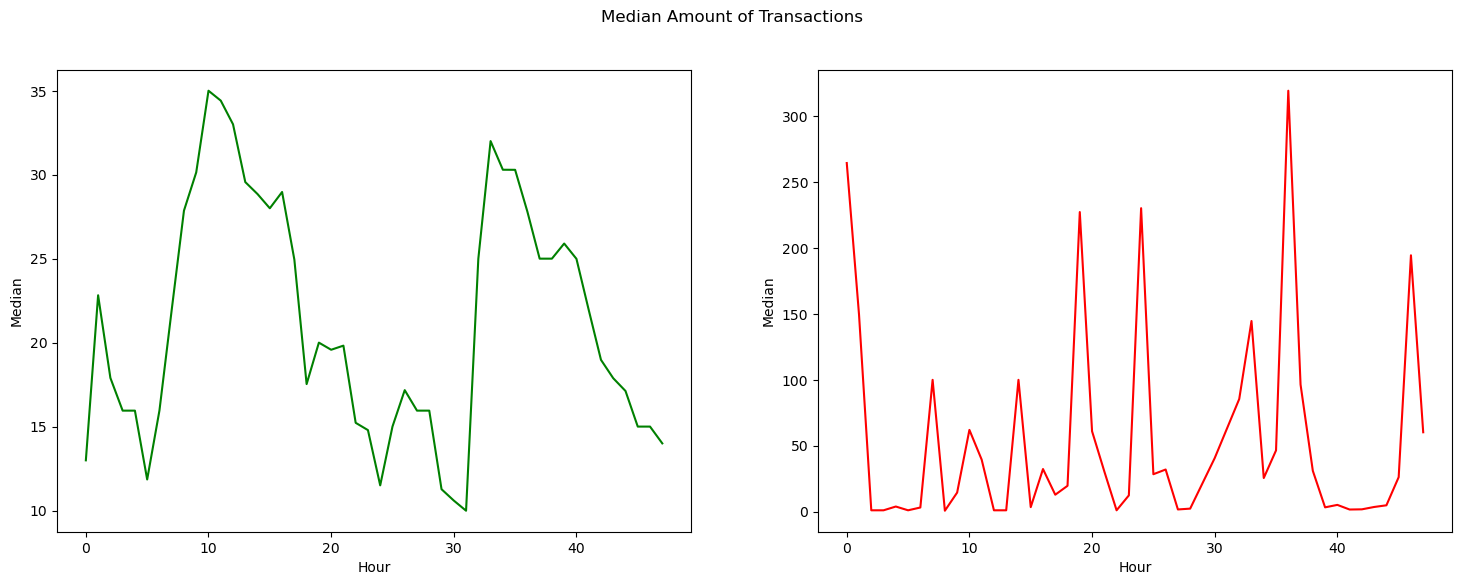

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=agg_df.loc[agg_df.Class==0], color="green")
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=agg_df.loc[agg_df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions")
plt.show();

**Visualize Minimum Transactions Amount Per Hour**

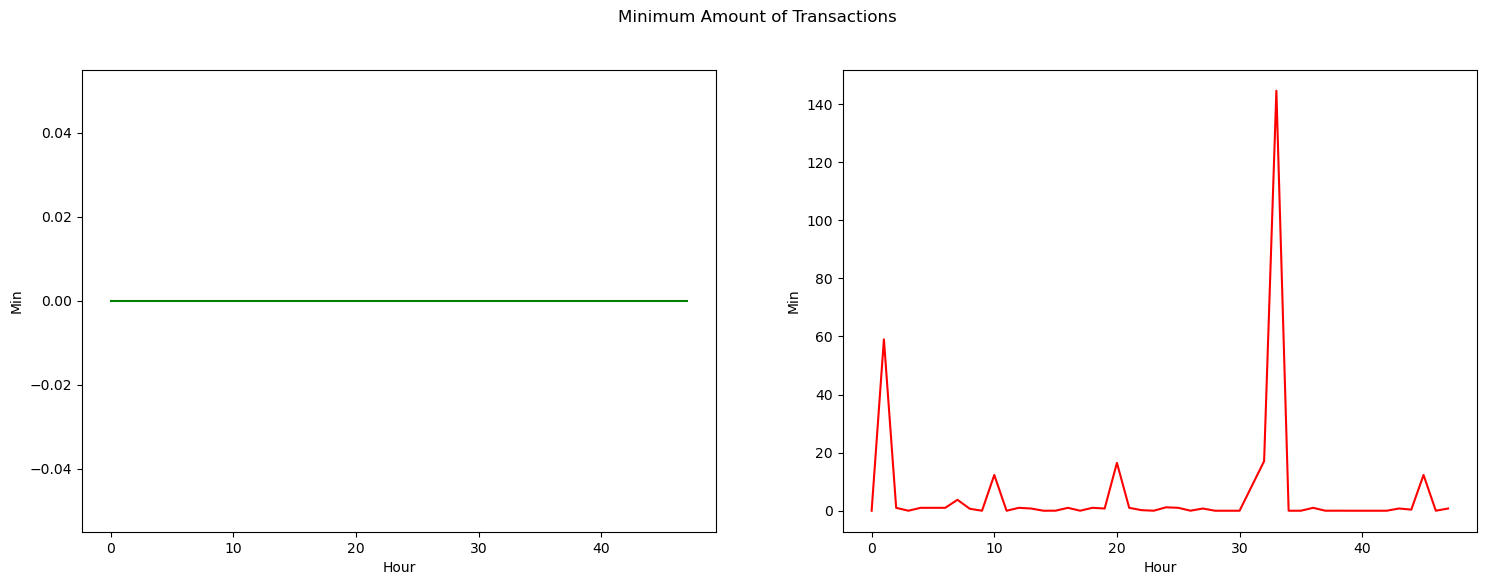

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=agg_df.loc[agg_df.Class==0], color="green")
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=agg_df.loc[agg_df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show();

**Visualize Maximum Transactions Amount Per Hour**

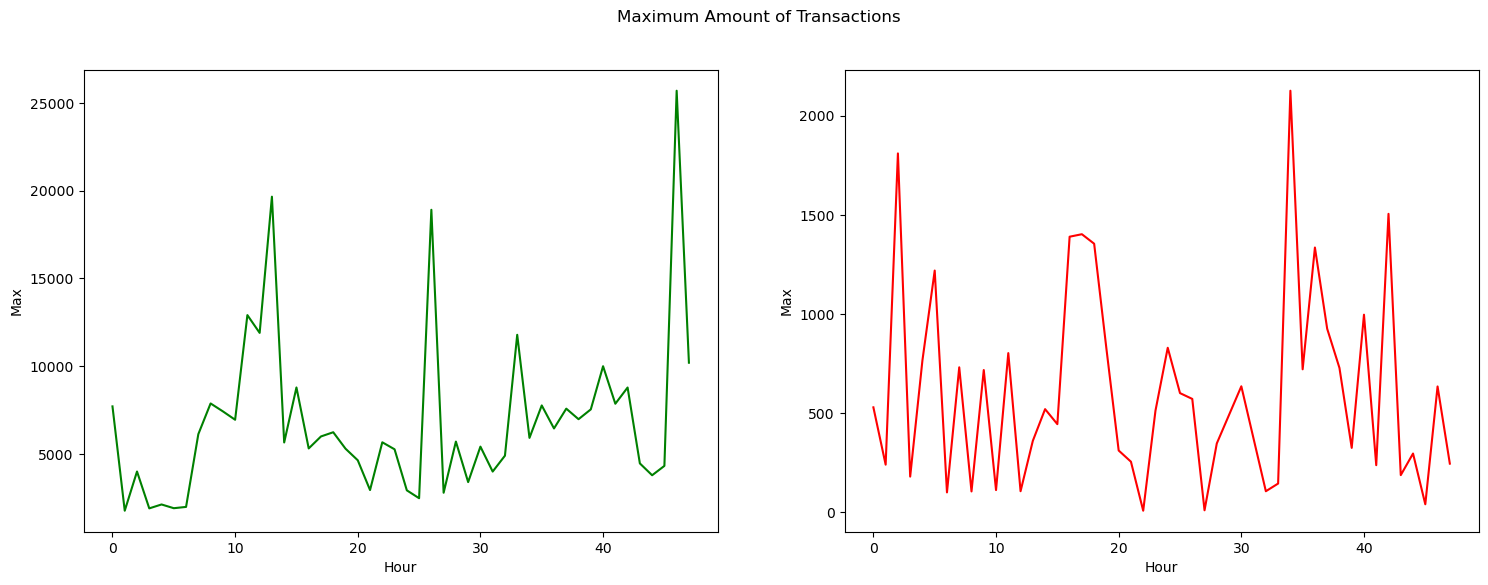

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=agg_df.loc[agg_df.Class==0], color="green")
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=agg_df.loc[agg_df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

**Visualize Total Number of Transactions Per Hour**

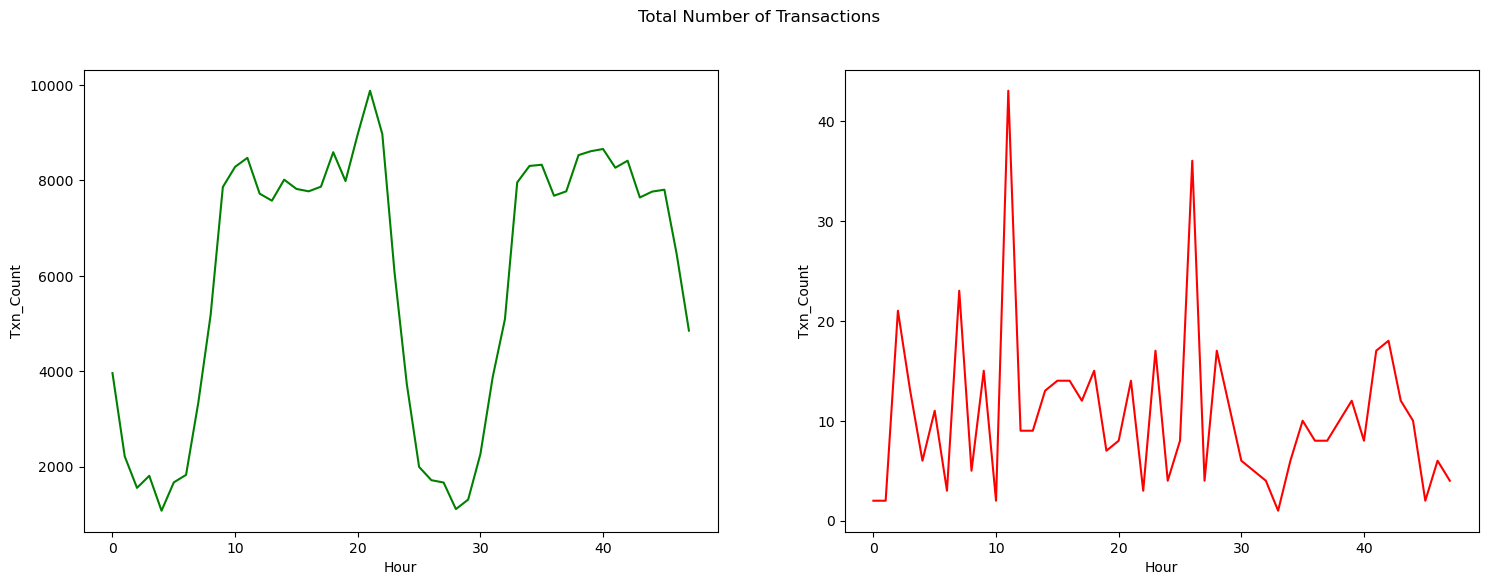

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Txn_Count", data=agg_df.loc[agg_df.Class==0], color="green")
s = sns.lineplot(ax = ax2, x="Hour", y="Txn_Count", data=agg_df.loc[agg_df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

**Card Transaction Amount**

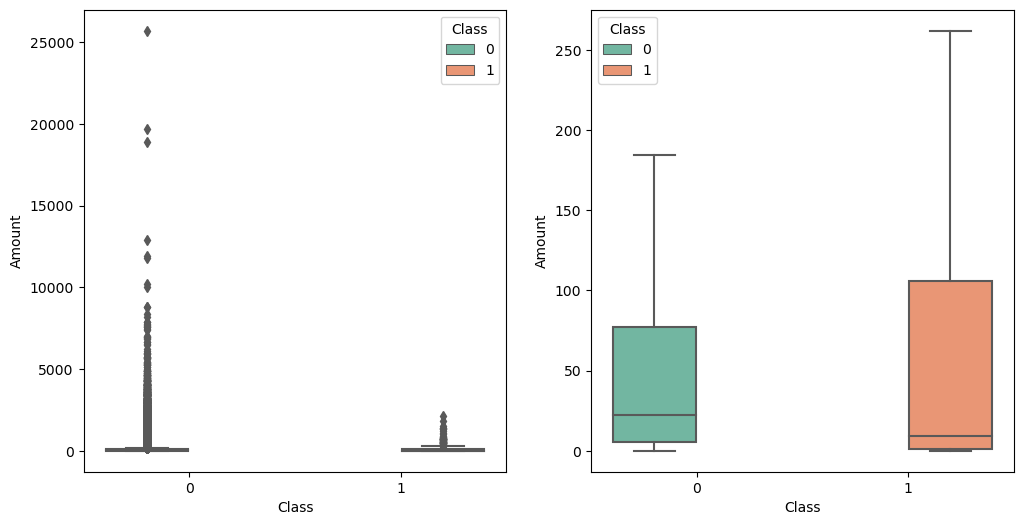

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data, palette="Set2",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data, palette="Set2",showfliers=False)
plt.show();

### Feature Correlation

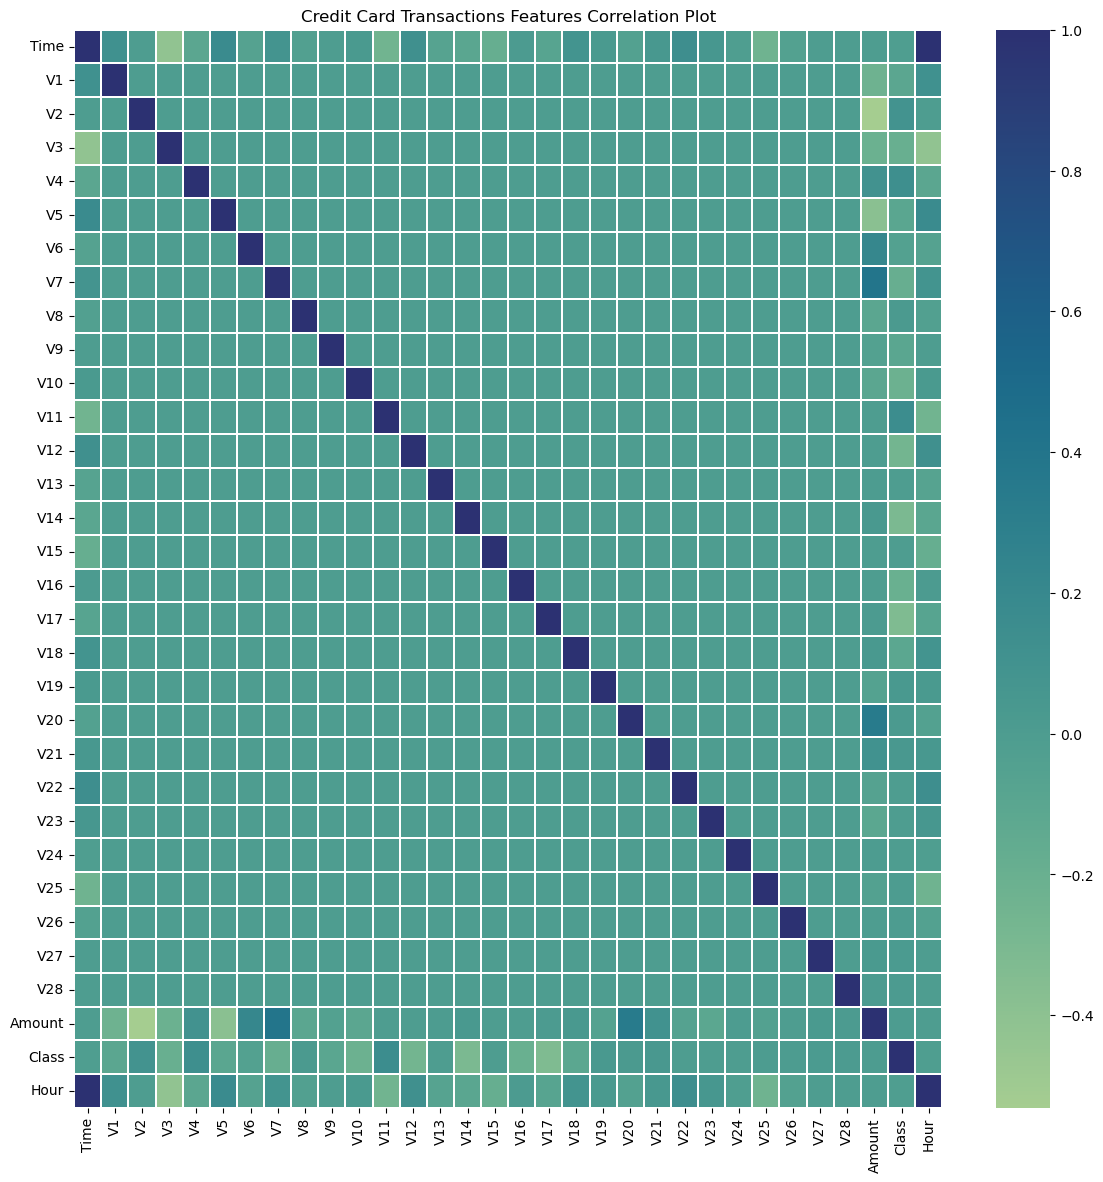

In [18]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions Features Correlation Plot')
corr = data.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="crest")
plt.show()

**Observations**
- As expected, there is no notable correlation between features **V1**-**V28**. There are certain correlations between some of these features and **Time** (inverse correlation with **V3**) and **Amount** (direct correlation with **V7** and **V20**, inverse correlation with **V2** and **V5**).

#### Let's plot the Correlated and Inverse Correlated values on the same graph.

**First with the direct correlated values: (V20:Amount) and (V7:Amount).**

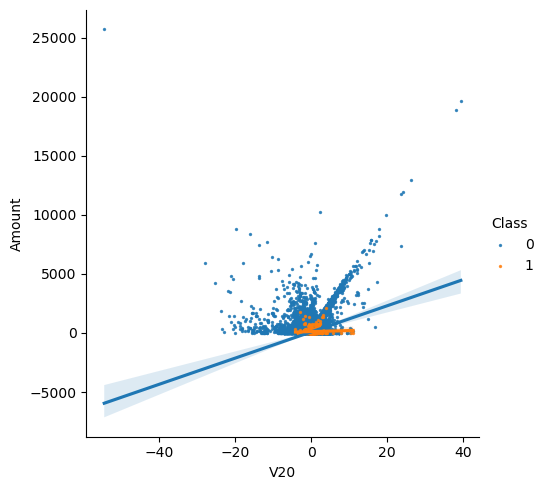

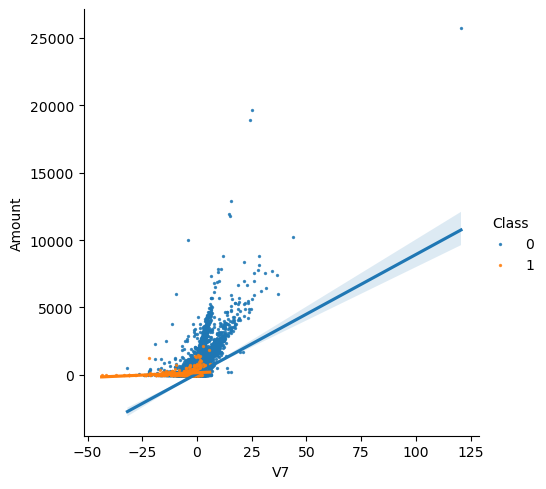

In [19]:
s = sns.lmplot(x='V20', y='Amount',data=data, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

**Observations**
- It's clear that the pair of features are correlated (the regression lines for **Class = 0** have a positive slope, whilst the regression line for **Class = 1** have a smaller positive slope).

**Let's plot the inverse correlated values : (V2:Amount) and (V5:Amount).**

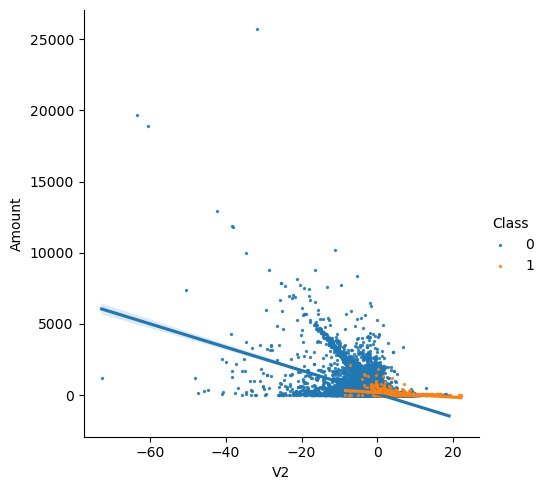

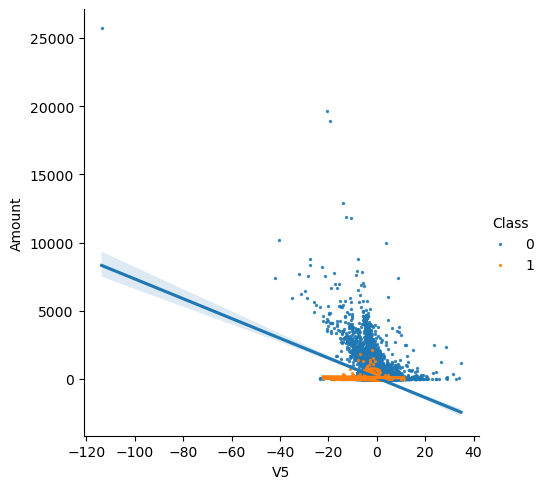

In [20]:
s = sns.lmplot(x='V2', y='Amount',data=data, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=data, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

**Observations**
- It's clear that the pair of features are inverse correlated (the regression lines for **Class = 0** have a negative slope while the regression lines for **Class = 1** have a very small negative slope).

### Feartures Density Plot

<Figure size 640x480 with 0 Axes>

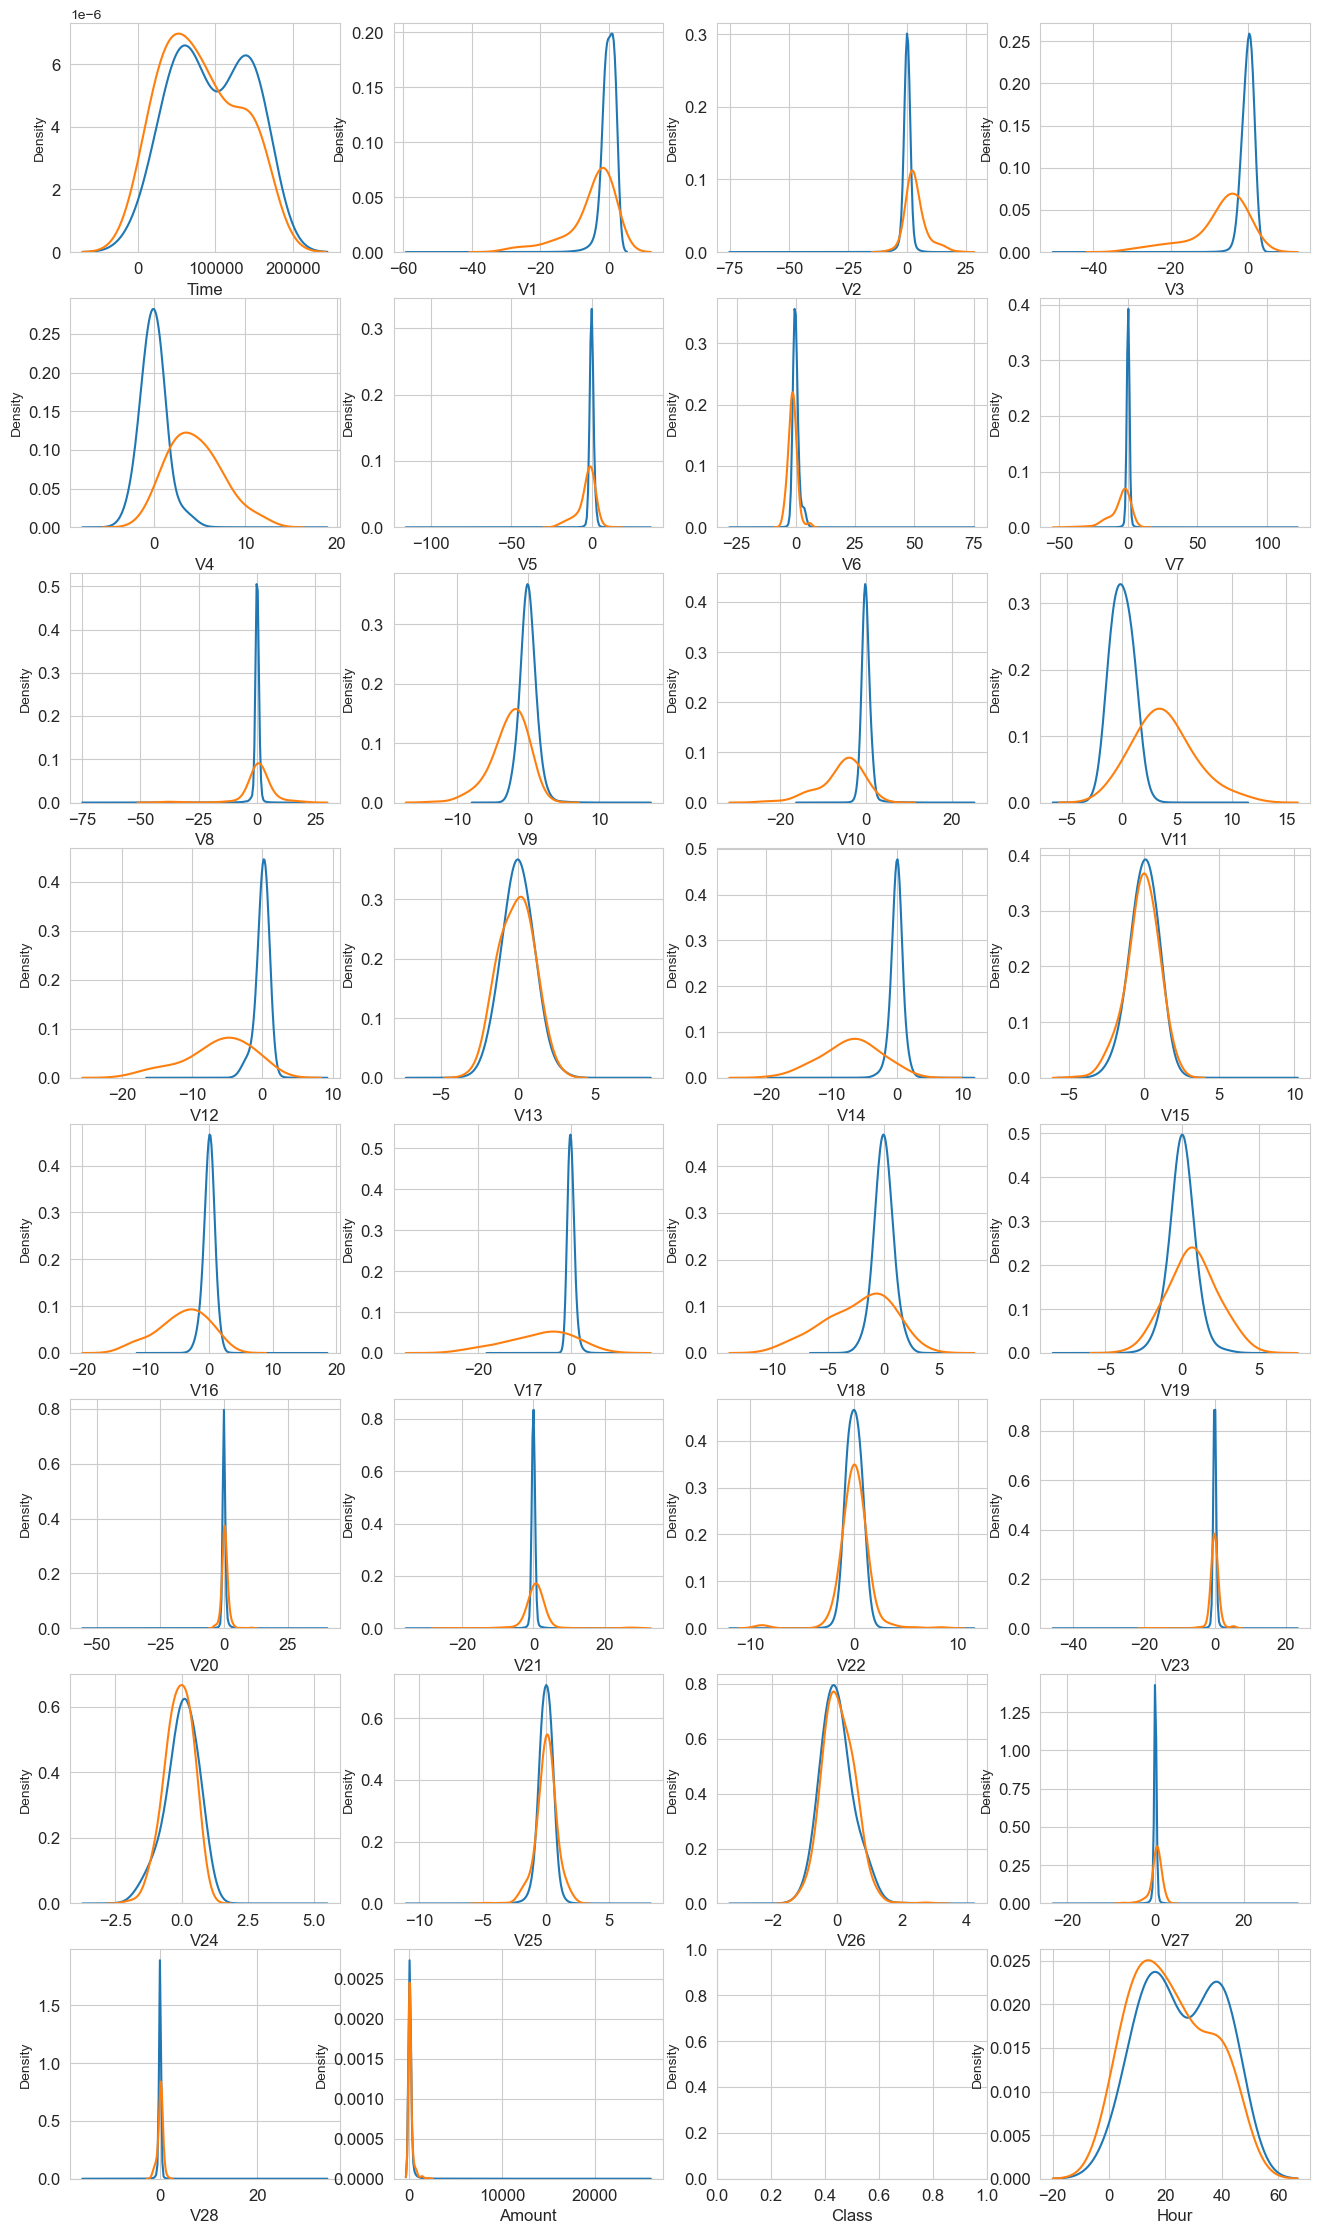

In [21]:
var = data.columns.values

i = 0
t0 = data.loc[data['Class'] == 0]
t1 = data.loc[data['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

**Observations**
- **V4**, **V11** have clearly separated distributions for **Class** values 0 and 1.
- **V12**, **V14**, **V18** are partially separated
- **V1**, **V2**, **V3**, **V10** have a quite distinct profile
- **V25**, **V26**, **V28** have similar profiles for the two values of **Class**.  

In general, with just few exceptions (**Time** and **Amount**), the features distribution for legitimate transactions (values of **Class = 0**)  is centered around 0, sometime with a long queue at one of the extremities. In the same time, the fraudulent transactions (values of **Class = 1**) have a skewed (asymmetric) distribution.

### Predictive/Classifier Models

In [22]:
# Create X, y dataframes
X = data.drop(['Class'], axis = 1)
y = data['Class']

### Define Predictors and Target features

Let's define the predictor and the target features. There are no categorical feature in this dataset.

In [23]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
              'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19','V20', 
              'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Hour']

### Split the dataset in Train, Test and Validation Sets

In [24]:
# Define the train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, shuffle=True)

### Start with a Basic Model

### Logistic Regression

In [25]:
# Let's create the basic model
lgr = LogisticRegression(max_iter=1000)

In [26]:
# Let's train the Logistic Regression using training data
lgr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [27]:
# Let's predict the target values
lgr_preds = lgr.predict(X_test)

### Features Importance (LogisticRegression)

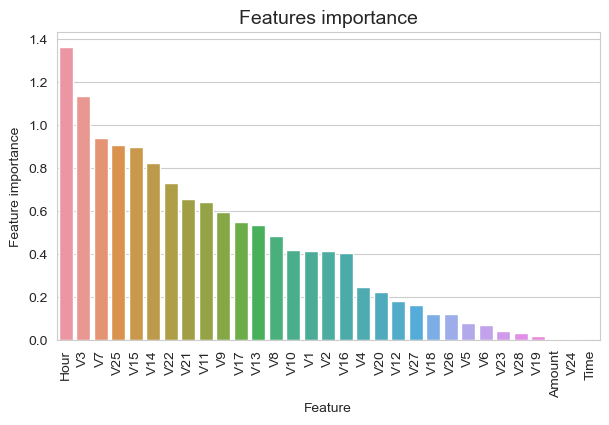

In [28]:
# Let's plot the important features
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': np.abs(lgr.coef_[0])})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

**Observations**
- Most important features are **Hour, V3, V7, V25, V15, V14**
- 3 least important features are **Time, V24, Amount**

**Confusion Matrix isn't very helpful for highly imbalanced dataset so let's calculate Area Under Curve (AUC) Score and plot it for this and all subsequent models.**

### Area Under Curve (LogisticRegression)

In [29]:
# Let's calculate the ROCAUC Score
roc_auc_scr = roc_auc_score(y_true=y_test, y_score=lgr_preds)
print(f'The ROC-AUC Score is : {roc_auc_scr: .8}')

The ROC-AUC Score is :  0.75500532


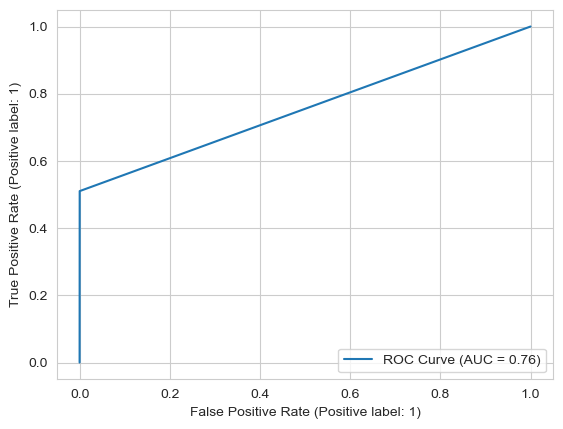

In [30]:
# Let's visualize the AUC
RocCurveDisplay.from_predictions(y_true=y_test, y_pred=lgr_preds, name="ROC Curve")

### Random Forest Classifier

In [31]:
# Let's create the model
rfc = RandomForestClassifier(n_jobs=4, random_state=42, criterion='gini', n_estimators=100, verbose=False)

In [32]:
# Let's train the RandomForestClassifier using training data
rfc.fit(X_train, y_train)

RandomForestClassifier(n_jobs=4, random_state=42, verbose=False)

In [33]:
# Let's predict the target values
rfc_preds = rfc.predict(X_test)

### Features Importance (RandomForestClassifier)

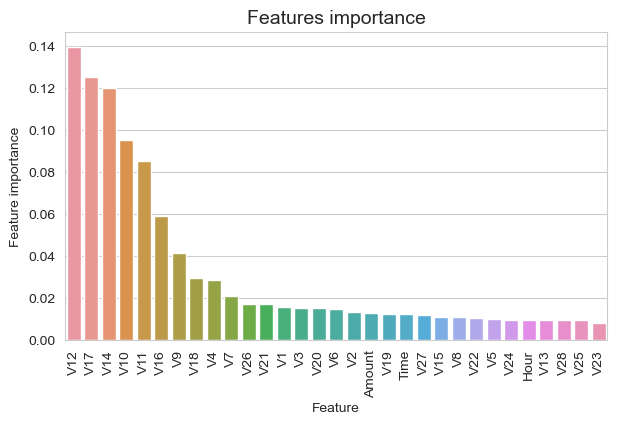

In [34]:
# Let's plot the important features
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': rfc.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

**Observations**
- Most important features are **V12, V17, V14, V10, V11, V16**
- 3 least important features are **V23, V25, V28**

### Area Under Curve (RandomForestClassifier)

In [35]:
# Let's calculate the ROCAUC Score
roc_auc_scr = roc_auc_score(y_true=y_test, y_score=rfc_preds)
print(f'The ROC-AUC Score is : {roc_auc_scr: .8}')

The ROC-AUC Score is :  0.88773752


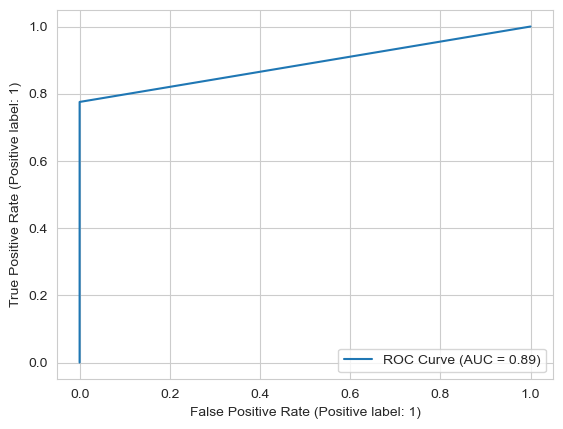

In [36]:
# Let's visualize the AUC
RocCurveDisplay.from_predictions(y_true=y_test, y_pred=rfc_preds, name="ROC Curve")

### XGBoost

In [37]:
# Prepare the train and test datasets
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

#Set other parameters
watchlist = [(dtrain, 'train')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = 42

In [38]:
# Let's train the model
xgb_model = xgb.train(params, dtrain, 1000, watchlist, early_stopping_rounds=50,maximize=True, verbose_eval=50)

[17:00:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-auc:0.87930
[50]	train-auc:0.92110
[100]	train-auc:0.93864
[150]	train-auc:0.97809
[200]	train-auc:0.98853
[250]	train-auc:0.99166
[300]	train-auc:0.99357
[350]	train-auc:0.99487
[400]	train-auc:0.99572
[450]	train-auc:0.99675
[500]	train-auc:0.99744
[550]	train-auc:0.99790
[600]	train-auc:0.99834
[650]	train-auc:0.99861
[700]	train-auc:0.99892
[750]	train-auc:0.99910
[800]	train-auc:0.99926
[850]	train-auc:0.99941
[900]	train-auc:0.99949
[950]	train-auc:0.99960
[999]	train-auc:0.99965


### Features Importance (XGBoost)

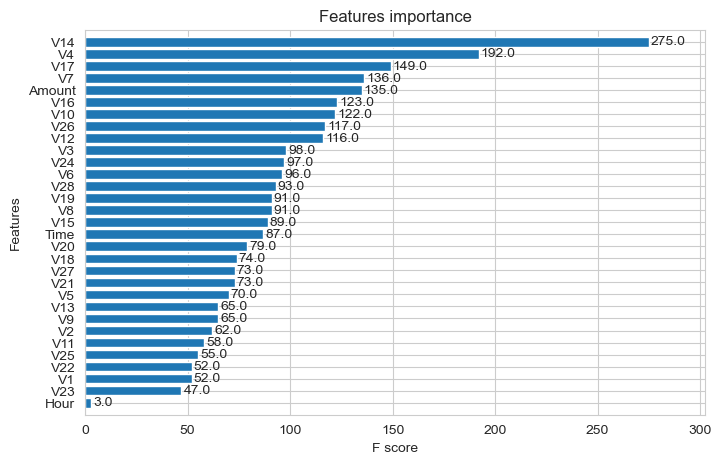

In [39]:
# Let's plot the important features
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(xgb_model, height=0.8, title="Features importance", ax=ax) 
plt.show()

**Observations**
- Most important features are **V14, V4, V17, V7, Amount, V16**
- 3 least important features are **Hour, V23, V1**

In [40]:
# Let's predict
xgb_preds = xgb_model.predict(dtest)

### Area Under Curve (XGBoost)

In [41]:
# Let's calculate the AUC Score
roc_auc_scr = roc_auc_score(y_test, xgb_preds)
print(f'The ROC-AUC Score is : {roc_auc_scr: .8}')

The ROC-AUC Score is :  0.98782577


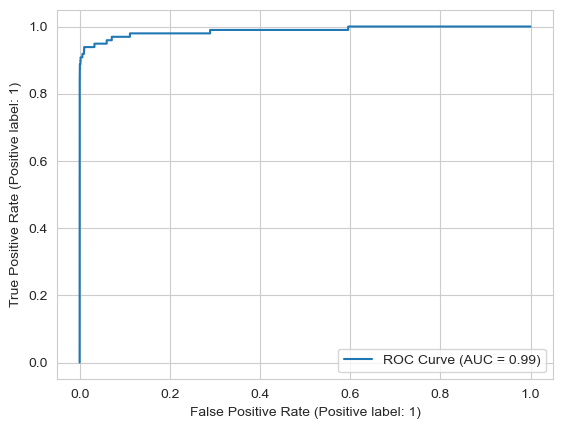

In [42]:
# Let's visualize the AUC
RocCurveDisplay.from_predictions(y_true=y_test, y_pred=xgb_preds, name="ROC Curve")

### Improving the Models

### Logistic Regression

In [43]:
# Define parameters for tuning using GridSearchCV and fit the model to find best params
lgr_params = [{'penalty':['l1', 'l2']}, 
              {'C':[0.001, 0.01, 0.1, 1, 10, 100]}]
lgr_tune = LogisticRegression(max_iter=1000)
lgr_grid = GridSearchCV(estimator = lgr_tune, param_grid = lgr_params, return_train_score=True)
lgr_grid_start = time.time()
lgr_grid.fit(X_train, y_train)
lgr_grid_stop = time.time()
print(f'Logistic Regression Grid Search Time : {(lgr_grid_stop - lgr_grid_start): .8f}s')

Logistic Regression Grid Search Time :  248.57719374s


In [44]:
# Display the best params
lgr_grid.best_params_

{'C': 10}

In [45]:
# Let's predict the target values
lgr_grid_preds = lgr_grid.predict(X_test)

### Area Under Curve (LogisticRegression)

In [46]:
# Let's calculate the ROCAUC Score
roc_auc_scr = roc_auc_score(y_true=y_test, y_score=lgr_grid_preds)
print(f'The ROC-AUC Score is : {roc_auc_scr: .8}')

The ROC-AUC Score is :  0.75500532


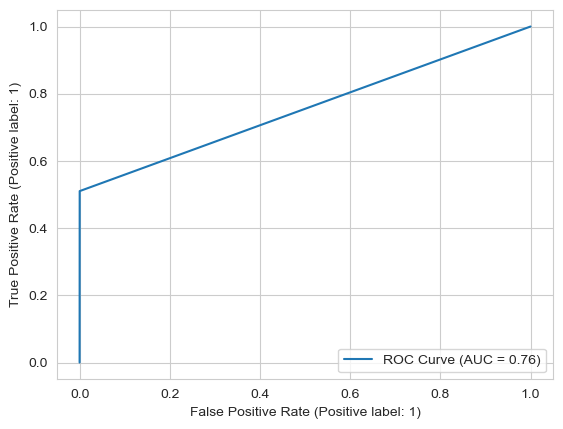

In [47]:
# Let's visualize the AUC
RocCurveDisplay.from_predictions(y_true=y_test, y_pred=lgr_grid_preds, name="ROC Curve")

### RandomForestClassifier

In [48]:
# # Random Forest Classifier
# # Use RandomizedSearchCV to find the hyperparameters best values
# rfc_pipe = Pipeline([('rfc', RandomForestClassifier(random_state=42))])
# rfc_params = {'rfc__n_estimators': [100, 200, 300],
#               'rfc__max_features': ['sqrt', 'log2'], 
#               'rfc__max_depth': range(1, 20, 2)]
#          }
# rfc_grid = RandomizedSearchCV(estimator=rfc_pipe, 
#                               n_iter = 100,
#                               param_distributions=rfc_params, 
#                               scoring='roc_auc', 
#                               cv=5,
#                               return_train_score=True)
# rfc_grid_start = time.time()
# rfc_grid.fit(X_train, y_train)
# rfc_grid_stop = time.time()
# print(f'RandomForestClassifier Grid Search Time : {(rfc_grid_stop - rfc_grid_start): .8f}s')

In [49]:
# # Display the best params
# rfc_grid.best_params_

In [50]:
# # Let's predict the target values
# rfc_grid_preds = rfc_grid.predict(X_test)

### Area Under Curve (RandomForestClassifier)

In [51]:
# # Let's calculate the ROCAUC Score
# roc_auc_scr = roc_auc_score(y_true=y_test, y_score=rfc_grid_preds)
# print(f'The ROC-AUC Score is : {roc_auc_scr: .8}')

In [52]:
# RocCurveDisplay.from_predictions(y_true=y_test, y_pred=rfc_grid_preds, name="ROC Curve")

### XGBoost

In [53]:
# # Define the XGB params
# xgb_params = {'min_child_weight': [1, 5, 10],
#               'gamma': [0.5, 1, 1.5, 2],
#               'subsample': [0.6, 0.8, 1.0],
#               'colsample_bytree': [0.6, 0.8, 1.0],
#               'max_depth': [3, 4, 5]
#              }

In [54]:
# # Define the model with initial params
# xgb_tune = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
#                     silent=True, nthread=1)

In [55]:
# # Use RandomizedSearchCV to fine tune the hyperparameters
# folds = 3
# param_comb = 5
# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)
# xgb_grid = RandomizedSearchCV(xgb_tune, 
#                               param_distributions=xgb_params, 
#                               n_iter=param_comb, 
#                               scoring='roc_auc', 
#                               n_jobs=4, 
#                               cv=skf.split(X_train,y_train), 
#                               verbose=3, 
#                               random_state=42,
#                               return_train_score=True)

In [56]:
# # Fit the training data to grid and find the best params
# xgb_grid_start = time.time()
# xgb_grid.fit(X_train, y_train)
# xgb_grid_stop = time.time()
# print(f'XGBoost Grid Search Time : {(xgb_grid_stop - xgb_grid_start): .8f}s')